In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/kaggle/input/videoframedata/new_frame_data.csv')
df.head()

,video_id,frame_path,question,answer,refined_answer,class
0,Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhair...,/kaggle/input/videoframedata/frame_data/frames...,What specific outfits are the people wearing?,The people are wearing traditional Bhutanese c...,The performers are adorned in traditional Newa...,Bhairab Dance
1,Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhair...,/kaggle/input/videoframedata/frame_data/frames...,What specific outfits are the people wearing?,The people are wearing traditional Bhutanese c...,The performers are adorned in traditional Newa...,Bhairab Dance
2,Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhair...,/kaggle/input/videoframedata/frame_data/frames...,What specific outfits are the people wearing?,The people are wearing traditional Bhutanese c...,The performers are adorned in traditional Newa...,Bhairab Dance
3,Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhair...,/kaggle/input/videoframedata/frame_data/frames...,What specific outfits are the people wearing?,The people are wearing traditional Bhutanese c...,The performers are adorned in traditional Newa...,Bhairab Dance
4,Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhair...,/kaggle/input/videoframedata/frame_data/frames...,What specific outfits are the people wearing?,The people are wearing traditional Bhutanese c...,The performers are adorned in traditional Newa...,Bhairab Dance


## FUCK MEE

In [5]:
%%capture
!pip install -q unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [6]:
from unsloth import FastVisionModel 
import torch


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [7]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [8]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, 
    finetune_language_layers   = True, 
    finetune_attention_modules = True, 
    finetune_mlp_modules       = True, 

    r = 16,         
    lora_alpha = 16,  
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  
    loftq_config = None, 
    
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [9]:
import json

output_path = "/kaggle/working/dataset.json"

# Convert the dataset to JSONL format
with open(output_path, "w") as f:
    for _, row in df.iterrows():
        json_data = {
            "image_path": row["frame_path"], 
            "question": row["question"],     
            "answer": row["refined_answer"]  
        }
        f.write(json.dumps(json_data) + "\n")

print(f"JSONL file saved to: {output_path}")

JSONL file saved to: /kaggle/working/dataset.json


In [10]:
data = []
with open(output_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

In [11]:
image_path = data[1]["image_path"]
question = data[1]["question"]
answer = data[1]["answer"]

print(f"Image Path: {image_path}")
print(f"Question: {question}")
print(f"Answer: {answer}")

Image Path: /kaggle/input/videoframedata/frame_data/frames/Bhaila Pyakhan __ Bhairav Dance Thimi __ Bhairab Naach __ Ashol Gora __--Ashok Gora--UCDdR23hgD-LU3fv8BINF_8A--DdFUPZ4KLCg_cut_clip_2/frame_1.jpg
Question: What specific outfits are the people wearing?
Answer: The performers are adorned in traditional Newari clothing, featuring vibrant red and yellow garments, along with elaborate masks symbolizing various deities like Kali Bhairav, Ganesh, and Kumari.


In [12]:
import json
from tqdm import tqdm
from PIL import Image

# Instruction for the dataset
instruction = "Answer the question based on the content of this image."

# Function to convert a single sample into a conversation format
def convert_to_conversation(sample):
    try:
        # Load the image using PIL
        image = Image.open(sample["image_path"])
        expected_size = (224, 224)
        # Resize the image
        image = image.resize(expected_size)
        
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": image}, # Pass the resized image
                    {"type": "text", "text": sample["question"]}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["answer"]}
                ]
            },
        ]
        return {"messages": conversation}
    except Exception as e:
        print(f"Error processing image {sample['image_path']}: {e}")
        return None # Skip the image if there's an error

In [13]:
converted_dataset = [convert_to_conversation(sample) for sample in tqdm(data, desc="Processing Samples")]
converted_dataset = [sample for sample in converted_dataset if sample is not None]

Processing Samples: 100%|██████████| 55244/55244 [21:05<00:00, 43.64it/s] 


In [14]:
from PIL import Image
from transformers import TextStreamer

model = FastVisionModel.for_inference(model)

image = converted_dataset[0]['messages'][0]['content'][1]['image']

instruction = "Answer the question based on the content of this image."
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},  
            {"type": "text", "text": instruction}
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
print(input_text)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
print(inputs)

# Define the text streamer
text_streamer = TextStreamer(
    tokenizer=tokenizer,
    skip_prompt=True  # Skip showing the input prompt in the output
)
print(text_streamer)

# Generate the output
with torch.no_grad():  # Disable gradient computation during inference
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                       use_cache=True, temperature=1.5, min_p=0.1)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>Answer the question based on the content of this image.<|eot_id|><|start_header_id|>assistant<|end_header_id|>


{'input_ids': tensor([[128000, 128006,    882, 128007,    271, 128256,  16533,    279,   3488,
           3196,    389,    279,   2262,    315,    420,   2217,     13, 128009,
         128006,  78191, 128007,    271]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[[[-0.1134, -0.1280, -0.2156,  ..., -1.1791, -1.2083, -1.2083],
            [-0.0988, -0.1134, -0.1864,  ..., -1.1791, -1.2083, -1.2083],
            [-0.0405, -0.0405, -0.0842,  ..., -1.1645, -1.2083, -1.2083],
            ...,
            [ 0.7041,  0.7041,  0.7333,  ...,  1.1712,  1.1566,  1.1566],
            [ 0.6895,  0.6895,  0.7187,  ...,  1.1566,  1.1420,  1.1420],
            [ 0.6895,  0.6895,  0.7187,  ...,  1.1566,  1.1

In [15]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",  

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [16]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.621 GB of memory reserved.


In [17]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 55,244 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.767400
2,2.806600
3,2.736100
4,2.598400
5,2.487800
6,2.325600
7,1.855500
8,1.696000
9,1.680600
10,1.757300


In [18]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1458.0646 seconds used for training.
24.3 minutes used for training.
Peak reserved memory = 9.816 GB.
Peak reserved memory for training = 1.195 GB.
Peak reserved memory % of max memory = 66.59 %.
Peak reserved memory for training % of max memory = 8.107 %.


In [19]:
from transformers import TextStreamer

# Enable the model for inference
model = FastVisionModel.for_inference(model)

# Load the image as a PIL image
image = converted_dataset[21200]['messages'][0]['content'][1]['image']

print(image)

# Prepare instruction and messages
instruction = "Which dance is begin performed?"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},  # Pass the resized PIL image directly
            {"type": "text", "text": instruction}
        ]
    }
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
print(input_text)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
print(inputs)

# Define the text streamer
text_streamer = TextStreamer(
    tokenizer=tokenizer,
    skip_prompt=True  # Skip showing the input prompt in the output
)
print(text_streamer)
with torch.no_grad():  # Disable gradient computation during inference
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                       use_cache=True, temperature=1.5, min_p=0.1)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7EF8400EA050>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>Which dance is begin performed?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


{'input_ids': tensor([[128000, 128006,    882, 128007,    271, 128256,  23956,  15612,    374,
           3240,  10887,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[[[[[-0.1718, -0.1718, -0.2010,  ...,  0.4851,  0.4851,  0.4851],
            [-0.1572, -0.1572, -0.1864,  ...,  0.4851,  0.4851,  0.4851],
            [-0.1134, -0.1134, -0.1280,  ...,  0.4851,  0.4851,  0.4851],
            ...,
            [ 1.3172,  1.3172,  1.3026,  ...,  1.0106,  0.9814,  0.9814],
            [ 1.3464,  1.3464,  1.3318,  ...,  1.0252,  0.9814,  0.9814],
            [ 1.3464,  1.3464,  1.3318,  ...,  1.0252,  0.9814,  0.9814]],

       

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
    processing_class=processor,
)

In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [19]:
trainer.push_to_hub()

events.out.tfevents.1737806568.cf84551c2d6e.31.0:   0%|          | 0.00/140k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ma0badi/LLaVa-NeXT-Video-demo/commit/718c7d225e48ffaa7d5e156882e280eb2208509f', commit_message='End of training', commit_description='', oid='718c7d225e48ffaa7d5e156882e280eb2208509f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ma0badi/LLaVa-NeXT-Video-demo', endpoint='https://huggingface.co', repo_type='model', repo_id='ma0badi/LLaVa-NeXT-Video-demo'), pr_revision=None, pr_num=None)

In [20]:
from transformers import pipeline

pipe = pipeline(model="ma0badi/LLaVa-NeXT-Video-demo")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


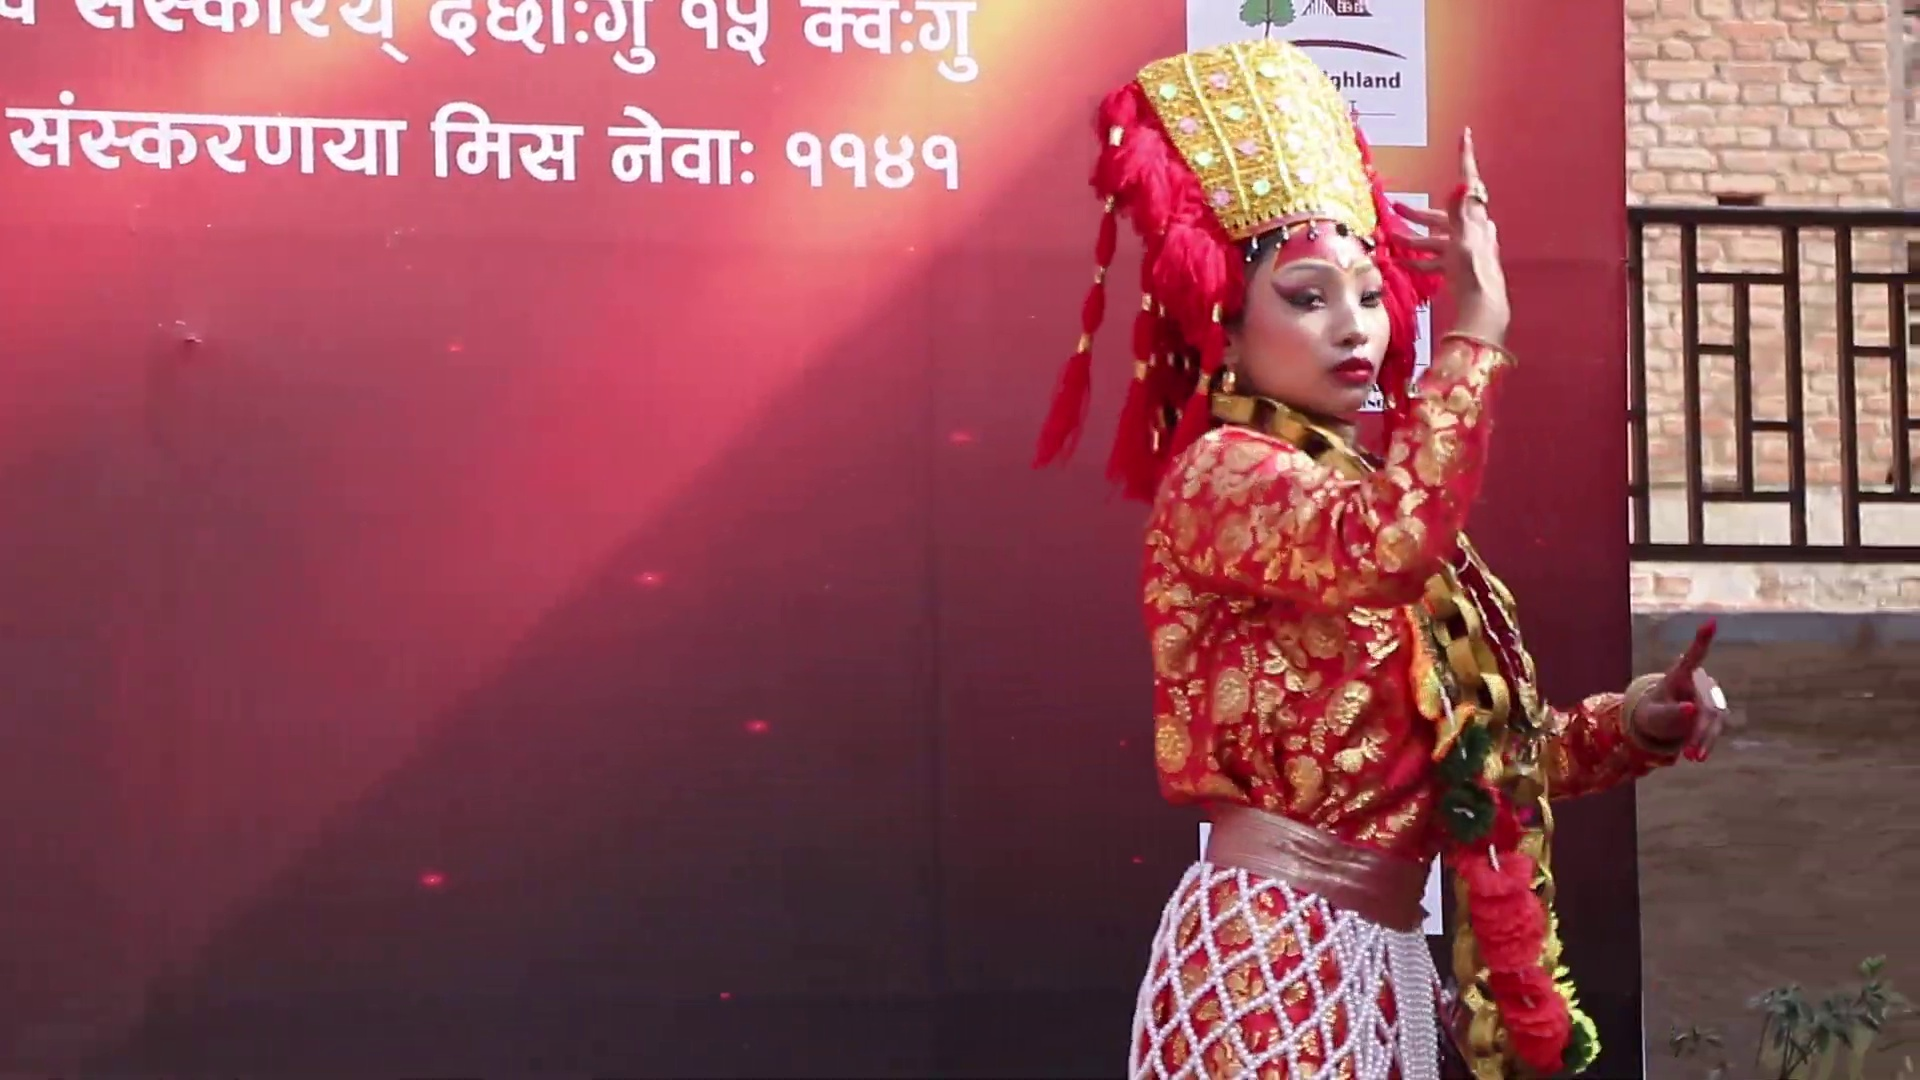

In [25]:
from PIL import Image

image = Image.open(dataset[10]['image_id'])
image

In [26]:
example = dataset[10]
image = Image.open(example['image_id'])
question = example['question']
print(question)
pipe(image, question, top_k=1)

How would you describe the dress style in the video?


[{'score': 0.031093468889594078, 'answer': 'asian'}]